In [2]:
import tensorflow as tf
import numpy as np
import nibabel as nib
import glob
import matplotlib.pyplot as plt
import nibabel as nib

In [3]:
from BSUnet import *

Using TensorFlow backend.


In [4]:
num_of_epochs = 1
global_best_metric = 0
def read_ct(path):
    img = nib.load(path)
    img = img.get_data()
    return img
def loadCT(path):
    images = glob.glob(path+"/volume*")
    segmentations = glob.glob(path+"/segmentation*", )
    images = sorted(images)
    segmentations = sorted(segmentations)
    return images , segmentations
def preprocess(imgs):
    imgs_p = np.ndarray((imgs.shape[0], img_rows, img_cols), dtype=np.uint8)
    for i in range(imgs.shape[0]):
        imgs_p[i] = resize(imgs[i], (img_cols, img_rows), preserve_range=True)

    imgs_p = imgs_p[..., np.newaxis]
    return imgs_p

In [5]:
def trainUnet(model,model_checkpoint,num_channels=2,num_ct=1,folders=2,batch_size=8):
    """
        Training by taking ct scans of only num_ct files and each data point of shape
        (512,512,num_channels)
    """
    path = "../data/batch"
    images ,segmentations = loadCT(path)
    for i in range(0,len(images),num_ct):
        print("image " + str(i)+" out of "+str(len(images)))
        X_train = []
        y_train = []
        img = read_ct(images[i])
        seg = read_ct(segmentations[i])
        print("Shape of img : ", img.shape)
        ##img shape: (512,512,X) X is the sum of all slices of num_ct files
        for j in range(0,img.shape[2]):
            ## simg shape (512,512)
            simg = img[:,:,j].astype(float)
            sseg = seg[:,:,j]
            ##HU clipping
            simg[simg >250 ] = 250
            simg[simg < -200] = -200
            ## Normalization
            simg -= -200
            simg /= 450
            ## treating tumor as part of liver
            sseg[sseg > 0] = 1
            if np.sum(sseg == 1)>0 :
                X_train.append(simg)
                y_train.append(sseg)
        print("Len of X_train ",len(X_train))
        X_train = np.array(X_train)
        y_train = np.array(y_train)
        X_train = X_train[...,np.newaxis]
        y_train = y_train[...,np.newaxis]
        print("shape of X_train ",X_train.shape)
        print("Shape of y_train ",y_train.shape)
        model.fit(X_train,y_train,callbacks=[model_checkpoint],batch_size=batch_size) ## set epoch to 1
    return model

In [6]:
def evaluate(model,fromIndex,batch_size=8):
    path = "../data/Test"
    images ,segmentations = loadCT(path)
    histot = []
    for i in range(fromIndex,len(images)):
        print("image " + str(i))
        X_test = []
        y_test = []
        img = read_ct(images[i])
        seg = read_ct(segmentations[i])
        print("Shape of img : ", img.shape)
        ##img shape: (512,512,X) X is the sum of all slices of num_ct files
        for j in range(0,img.shape[2]):
            simg = img[:,:,j].astype(float)
            sseg = seg[:,:,j]
            ## simg shape (512,512)
            ##HU clipping
            simg[simg >250 ] = 250
            simg[simg < -200] = -200
            ## Normalization
            simg -= -200
            simg /= 450
            ## treating tumor as part of liver
            sseg[sseg > 0] = 1
            if np.sum(sseg == 1)>0 :
                X_test.append(simg)
                y_test.append(sseg)
        print("Len of X_test ",len(X_test))
        X_test = np.array(X_test)
        y_test = np.array(y_test)
        X_test = X_test[...,np.newaxis]
        y_test = y_test[...,np.newaxis]
#         mean = np.mean(X_test)  # mean for data centering
#         std = np.std(X_test)  # std for data normalization

#         X_test -= mean
#         X_test /= std
        print("shape of X_train ",X_test.shape)
        print("Shape of y_train ",y_test.shape)
        history = model.evaluate(X_test,y_test,batch_size=batch_size)
        print(history)
        histot.append(history)
    return histot

In [7]:
num_channels = 1
num_ct = 1
# model = liverUnet(input_size=(512,512,num_channels))
# model = get_unet_sorr(input_size=(512,512,num_channels))
model = segmentedUnet(input_size=(512,512,num_channels),output_ch=(512,512,num_channels))
model_checkpoint = ModelCheckpoint('./weights/BSUnet/best_weights.hdf5', monitor='loss',verbose=1, save_best_only=True)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 512, 512, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 512, 512, 8)  16          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 512, 512, 8)  16          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (

In [16]:
# num_epochs = 2
# for e in range(num_epochs):
#     print("*"*50)
#     print("** epoch ",e)
#     model = trainUnet(model,model_checkpoint,num_channels=num_channels,num_ct=num_ct,folders=1,batch_size=10)
#     model.save_weights('./weights/BSUnet/after_epoch{}.hdf5'.format(e))
#     model.save_weights('./weights/BSUnet/final_weights.hdf5')

In [8]:
model.load_weights('./weights/BSUnet/final_weights.hdf5')

# Validation

In [9]:
# model.load_weights('unet_liver_preprocess.hdf5')
# model.load_weights('unet_liver_after_epoch.hdf5')
h = evaluate(model,0,batch_size=2)

image 0
Shape of img :  (512, 512, 75)
Len of X_test  29
shape of X_train  (29, 512, 512, 1)
Shape of y_train  (29, 512, 512, 1)
29/29 [==============================] - 3s 91ms/step
[0.023470350348486983, 0.8668281446765016]
image 1
Shape of img :  (512, 512, 123)
Len of X_test  29
shape of X_train  (29, 512, 512, 1)
Shape of y_train  (29, 512, 512, 1)
29/29 [==============================] - 1s 26ms/step
[0.017623794939497422, 0.8901054170624964]
image 2
Shape of img :  (512, 512, 501)
Len of X_test  181
shape of X_train  (181, 512, 512, 1)
Shape of y_train  (181, 512, 512, 1)
181/181 [==============================] - 5s 27ms/step
[0.026821096720384918, 0.8849147524561177]
image 3
Shape of img :  (512, 512, 466)
Len of X_test  167
shape of X_train  (167, 512, 512, 1)
Shape of y_train  (167, 512, 512, 1)
167/167 [==============================] - 4s 27ms/step
[0.10519298864807376, 0.8298692811548174]
image 4
Shape of img :  (512, 512, 455)
Len of X_test  189
shape of X_train  (189, 5

In [10]:
alp = np.array(h)
y = np.mean(alp,axis=0)
print(y)
print(global_best_metric)
# if y[1]>global_best_metric[1]:
#     global_best_metric = y

[0.04409864 0.85733786]
0


In [20]:
values = {}
histories = {}
for e in range(12):
    model.load_weights('./weights/BSUnet/after_epoch{}.hdf5'.format(e))
    h = evaluate(model,0,batch_size = 2)
    alp = np.array(h)
    mean = np.mean(h,axis=0)
    values[e] = mean
    histories[e] = h

image 0
Shape of img :  (512, 512, 75)
Len of X_test  29
shape of X_train  (29, 512, 512, 1)
Shape of y_train  (29, 512, 512, 1)
29/29 [==============================] - 1s 28ms/step
[0.03761035422312802, 0.7985380536009525]
image 1
Shape of img :  (512, 512, 123)
Len of X_test  29
shape of X_train  (29, 512, 512, 1)
Shape of y_train  (29, 512, 512, 1)
29/29 [==============================] - 1s 27ms/step
[0.043633664540689565, 0.7691971659660339]
image 2
Shape of img :  (512, 512, 501)
Len of X_test  181
shape of X_train  (181, 512, 512, 1)
Shape of y_train  (181, 512, 512, 1)
181/181 [==============================] - 5s 27ms/step
[0.026590822604150403, 0.8231836661708655]
image 3
Shape of img :  (512, 512, 466)
Len of X_test  167
shape of X_train  (167, 512, 512, 1)
Shape of y_train  (167, 512, 512, 1)
167/167 [==============================] - 4s 27ms/step
[0.0940999671326069, 0.7319049907804321]
image 4
Shape of img :  (512, 512, 455)
Len of X_test  189
shape of X_train  (189, 512

176/176 [==============================] - 5s 27ms/step
[0.01587007920501161, 0.7970211653528995]
image 16
Shape of img :  (512, 512, 518)
Len of X_test  186
shape of X_train  (186, 512, 512, 1)
Shape of y_train  (186, 512, 512, 1)
186/186 [==============================] - 5s 27ms/step
[0.016205856461398382, 0.8416911416844483]
image 17
Shape of img :  (512, 512, 541)
Len of X_test  177
shape of X_train  (177, 512, 512, 1)
Shape of y_train  (177, 512, 512, 1)
177/177 [==============================] - 5s 27ms/step
[0.02612309024200938, 0.8285806746456225]
image 18
Shape of img :  (512, 512, 541)
Len of X_test  179
shape of X_train  (179, 512, 512, 1)
Shape of y_train  (179, 512, 512, 1)
179/179 [==============================] - 5s 27ms/step
[0.01769860227483028, 0.8467887195766001]
image 19
Shape of img :  (512, 512, 549)
Len of X_test  173
shape of X_train  (173, 512, 512, 1)
Shape of y_train  (173, 512, 512, 1)
173/173 [==============================] - 5s 27ms/step
[0.019891465739

Len of X_test  188
shape of X_train  (188, 512, 512, 1)
Shape of y_train  (188, 512, 512, 1)
188/188 [==============================] - 5s 27ms/step
[0.10335535349998068, 0.6974962979339637]
image 12
Shape of img :  (512, 512, 517)
Len of X_test  139
shape of X_train  (139, 512, 512, 1)
Shape of y_train  (139, 512, 512, 1)
139/139 [==============================] - 4s 27ms/step
[0.10115511420604995, 0.7656091600591601]
image 13
Shape of img :  (512, 512, 534)
Len of X_test  169
shape of X_train  (169, 512, 512, 1)
Shape of y_train  (169, 512, 512, 1)
169/169 [==============================] - 5s 27ms/step
[0.05301401990096597, 0.7680193915864668]
image 14
Shape of img :  (512, 512, 841)
Len of X_test  250
shape of X_train  (250, 512, 512, 1)
Shape of y_train  (250, 512, 512, 1)
250/250 [==============================] - 7s 27ms/step
[0.05818613463640213, 0.697849076601502]
image 15
Shape of img :  (512, 512, 537)
Len of X_test  176
shape of X_train  (176, 512, 512, 1)
Shape of y_train 

Shape of img :  (512, 512, 501)
Len of X_test  181
shape of X_train  (181, 512, 512, 1)
Shape of y_train  (181, 512, 512, 1)
181/181 [==============================] - 5s 27ms/step
[0.02385331439471788, 0.8710268825014091]
image 3
Shape of img :  (512, 512, 466)
Len of X_test  167
shape of X_train  (167, 512, 512, 1)
Shape of y_train  (167, 512, 512, 1)
167/167 [==============================] - 5s 27ms/step
[0.05713113148635376, 0.82220761165996]
image 4
Shape of img :  (512, 512, 455)
Len of X_test  189
shape of X_train  (189, 512, 512, 1)
Shape of y_train  (189, 512, 512, 1)
189/189 [==============================] - 5s 27ms/step
[0.04158081565170534, 0.8682089703817847]
image 5
Shape of img :  (512, 512, 605)
Len of X_test  142
shape of X_train  (142, 512, 512, 1)
Shape of y_train  (142, 512, 512, 1)
142/142 [==============================] - 4s 27ms/step
[0.021898385238978014, 0.799981920064991]
image 6
Shape of img :  (512, 512, 588)
Len of X_test  139
shape of X_train  (139, 512

177/177 [==============================] - 5s 27ms/step
[0.03294483498054541, 0.8673052176449048]
image 18
Shape of img :  (512, 512, 541)
Len of X_test  179
shape of X_train  (179, 512, 512, 1)
Shape of y_train  (179, 512, 512, 1)
179/179 [==============================] - 5s 28ms/step
[0.029780610586781907, 0.845864973592981]
image 19
Shape of img :  (512, 512, 549)
Len of X_test  173
shape of X_train  (173, 512, 512, 1)
Shape of y_train  (173, 512, 512, 1)
173/173 [==============================] - 5s 27ms/step
[0.025566053430070682, 0.8607855924762479]
image 0
Shape of img :  (512, 512, 75)
Len of X_test  29
shape of X_train  (29, 512, 512, 1)
Shape of y_train  (29, 512, 512, 1)
29/29 [==============================] - 1s 27ms/step
[0.01874634231729754, 0.8785766239181675]
image 1
Shape of img :  (512, 512, 123)
Len of X_test  29
shape of X_train  (29, 512, 512, 1)
Shape of y_train  (29, 512, 512, 1)
29/29 [==============================] - 1s 27ms/step
[0.019856201292111957, 0.869

Len of X_test  169
shape of X_train  (169, 512, 512, 1)
Shape of y_train  (169, 512, 512, 1)
169/169 [==============================] - 5s 27ms/step
[0.04542080899865846, 0.7946761985551897]
image 14
Shape of img :  (512, 512, 841)
Len of X_test  250
shape of X_train  (250, 512, 512, 1)
Shape of y_train  (250, 512, 512, 1)
250/250 [==============================] - 7s 27ms/step
[0.0399520938238129, 0.7996580593027175]
image 15
Shape of img :  (512, 512, 537)
Len of X_test  176
shape of X_train  (176, 512, 512, 1)
Shape of y_train  (176, 512, 512, 1)
176/176 [==============================] - 5s 27ms/step
[0.013972196419755082, 0.8476342158921232]
image 16
Shape of img :  (512, 512, 518)
Len of X_test  186
shape of X_train  (186, 512, 512, 1)
Shape of y_train  (186, 512, 512, 1)
186/186 [==============================] - 5s 27ms/step
[0.014033514688352263, 0.9079291685909954]
image 17
Shape of img :  (512, 512, 541)
Len of X_test  177
shape of X_train  (177, 512, 512, 1)
Shape of y_trai

# Testing

In [20]:
images ,segmentations = loadCT("../data/Test")
img = read_ct(images[11])
seg = read_ct(segmentations[11])
X_test = []
y_test = []
for j in range(0,img.shape[2]):
    simg = img[:,:,j].astype(float)
    sseg = seg[:,:,j]
    ## simg shape (512,512)
    ##HU clipping
    simg[simg >250 ] = 250
    simg[simg < -200] = -200
    ## Normalization
    simg -= -200
    simg /= 450
    ## treating tumor as part of liver
    sseg[sseg > 0] = 1
    if np.sum(sseg == 1)>0 :
        X_test.append(simg)
        y_test.append(sseg)
print("Len of X_test ",len(X_test))
X_test = np.array(X_test)
y_test = np.array(y_test)
X_test = X_test[...,np.newaxis]
y_test = y_test[...,np.newaxis]
print("shape of X_train ",X_test.shape)
print("Shape of y_train ",y_test.shape)
# history = model.evaluate(X_test,y_test,batch_size=batch_size)


Len of X_test  188
shape of X_train  (188, 512, 512, 1)
Shape of y_train  (188, 512, 512, 1)


In [21]:
idx = 100

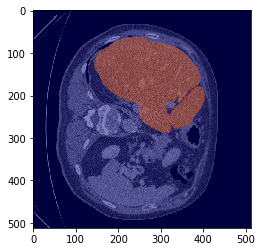

In [22]:
plt.imshow(X_test[idx][:,:,0].reshape(512,512), cmap="gray")
plt.imshow(y_test[idx][:,:,0].reshape(512,512), cmap='jet', alpha=0.5)

In [23]:
result = model.predict(X_test[idx:idx+1])

In [24]:
result.shape

(1, 512, 512, 1)

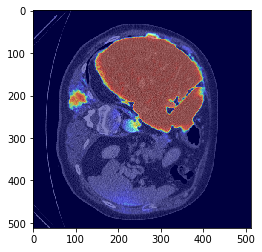

In [25]:
plt.imshow(X_test[idx][:,:,0].reshape(512,512), cmap="gray")
plt.imshow(result[0][:,:,0].reshape(512,512), cmap='jet', alpha=0.5)

In [ ]:
np.sum(result>0)

In [21]:
values

{0: array([0.0418612 , 0.78567727]),
 1: array([0.04197188, 0.77944628]),
 2: array([0.0406186 , 0.78734599]),
 3: array([0.05247904, 0.78487905]),
 4: array([0.05116967, 0.79322666]),
 5: array([0.02923774, 0.83191955]),
 6: array([0.02762009, 0.84395686]),
 7: array([0.0330318 , 0.83020694]),
 8: array([0.03711082, 0.83211061]),
 9: array([0.03807193, 0.85213671]),
 10: array([0.03003191, 0.85433187]),
 11: array([0.04079092, 0.81779074])}

In [25]:
histories[9]

[[0.01874634231729754, 0.8785766239181675],
 [0.019856201292111957, 0.8693032507174487],
 [0.02410489370279755, 0.8865386696702168],
 [0.10930253252732808, 0.8221358880902568],
 [0.07592076976739225, 0.8160214544663196],
 [0.03219011627977163, 0.765966512905565],
 [0.026689796614721952, 0.8502893680237609],
 [0.053191045547758505, 0.8081649892991478],
 [0.027022241958402058, 0.8512914194202519],
 [0.04751986759418452, 0.876493532069479],
 [0.01028862902426491, 0.9079738494807056],
 [0.03336355914337006, 0.8696968194018019],
 [0.09006475757057075, 0.8319972197143294],
 [0.02628990909437368, 0.8695368398719373],
 [0.05316268357820809, 0.758912417174899],
 [0.016840616884027524, 0.8574773410380824],
 [0.014719986719810355, 0.8961518599331925],
 [0.027111475232273002, 0.8864738435785702],
 [0.029133761387484865, 0.8621590829859377],
 [0.025919323874572884, 0.8775731213453913]]